# Librerías y configuraciones


In [47]:
import pandas as pd
import numpy as np
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

-----

# Carga de datos

In [48]:
df_genres = pd.read_csv('data/df_genres.csv')
df_item_genre = pd.read_csv('data/df_item_genre.csv')
df_items = pd.read_csv('data/raw_steam_games.csv')
df_reviews = pd.read_csv('data/df_reviews.csv')
df_users_items = pd.read_csv('data/df_users_items.csv')
df_users = pd.read_csv('data/df_users.csv')

----------

# Sistema de recomendación

Función solicitada: 
def recomendacion_juego( id de producto ): Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.

In [49]:
df_reviews.head(2)

,user_id,item_id,recommend,posted_date,year,sentiment_analysis
0,76561197970982479,1250,True,2011-11-05,2011,2
1,76561197970982479,22200,True,2011-07-15,2011,2


Para esta primer entrega del sistema de recomendacion tomaremos solamente aquellos items que poseen reviews positivos sobre los items.

In [50]:
sist_recomendacion_df = df_reviews[df_reviews.sentiment_analysis == 2]

In [51]:
len(sist_recomendacion_df.item_id.unique())

2351

In [52]:
items_genres_ml = list(sist_recomendacion_df.item_id.unique())

Analizaremos las palabras que mas re repiten en los títulos de los items filtrados

In [53]:
df_palabras = df_items[['title','item_id']][df_items.item_id.isin(items_genres_ml)]

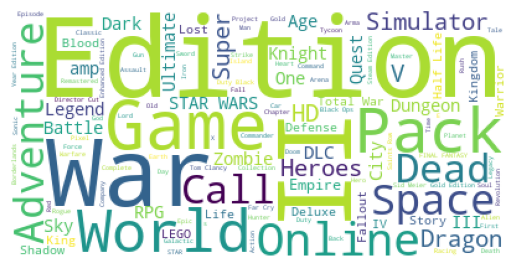

In [54]:
text = df_palabras.fillna(' ')
text['title'] = text['title'].astype('str')
stopwords = STOPWORDS
text_title = ' '.join(text['title'])
WC = WordCloud(
    background_color='white',
    stopwords=stopwords,
)
for i in [text_title]:
    WC.generate(i)
    plt.figure()
    plt.imshow(WC)
    plt.axis('off')
    plt.show()

Podemos ver que las palabras mas usadas en los títulos son: Edition, Game, ii, on line, pack, que estan relacionadas a caracteristicas del juego y War, World, Adventure, space, Dragon, Dead, que están mas relacionadas con las temáticas de los juegos.

Para el sistema de recomendación utilizaremos los campos item_id, genres y title.	

In [55]:
genero_grouped = df_item_genre.groupby('item_id')['genres'].apply(lambda x: ', '.join(x)).reset_index()


In [56]:
genero_grouped.tail(2)

,item_id,genres
27619,2028103,"Action, Adventure"
27620,2028850,Action


In [57]:
sist_recomendacion_df =  genero_grouped[genero_grouped.item_id.isin(items_genres_ml)]

In [58]:
sist_recomendacion_df

,item_id,genres
0,10,Action
1,20,Action
2,30,Action
3,40,Action
4,50,Action
...,...,...
17448,516040,"Indie, Strategy"
17568,520550,"Indie, Simulation"
17615,521340,"Casual, Indie"
17654,521990,"Action, Indie"


In [59]:
sist_recomendacion_df = sist_recomendacion_df.merge(df_items[['item_id','title']], on='item_id',)

In [60]:
sist_recomendacion_df

,item_id,genres,title
0,10,Action,Counter-Strike
1,20,Action,Team Fortress Classic
2,30,Action,Day of Defeat
3,40,Action,Deathmatch Classic
4,50,Action,Half-Life: Opposing Force
...,...,...,...
2273,516040,"Indie, Strategy",Everything is Peachy
2274,520550,"Indie, Simulation",American Truck Simulator - Steering Creations ...
2275,521340,"Casual, Indie",True or False
2276,521990,"Action, Indie",Galactic Storm


In [61]:
sist_recomendacion_df.title = sist_recomendacion_df.title.str.title().str.strip()

In [62]:
sist_recomendacion_df['texto'] = sist_recomendacion_df.genres + " " + sist_recomendacion_df.title

In [63]:
sist_recomendacion_df

,item_id,genres,title,texto
0,10,Action,Counter-Strike,Action Counter-Strike
1,20,Action,Team Fortress Classic,Action Team Fortress Classic
2,30,Action,Day Of Defeat,Action Day Of Defeat
3,40,Action,Deathmatch Classic,Action Deathmatch Classic
4,50,Action,Half-Life: Opposing Force,Action Half-Life: Opposing Force
...,...,...,...,...
2273,516040,"Indie, Strategy",Everything Is Peachy,"Indie, Strategy Everything Is Peachy"
2274,520550,"Indie, Simulation",American Truck Simulator - Steering Creations ...,"Indie, Simulation American Truck Simulator - S..."
2275,521340,"Casual, Indie",True Or False,"Casual, Indie True Or False"
2276,521990,"Action, Indie",Galactic Storm,"Action, Indie Galactic Storm"


------------------

ML

In [64]:
# Instanciamos el CV
vectorizer = CountVectorizer()
stopwords = STOPWORDS
# eliminamos las "stop words", palabras comunes no informativas
tf = TfidfVectorizer(stop_words='english')

# calculamos los features para cada ítem (texto)
tfidf_matrix = tf.fit_transform(sist_recomendacion_df['texto'])

# calculamos las similitudes entre todos los documentos
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
n = 5

results = {} 
for idx, row in sist_recomendacion_df.iterrows():
    # guardamos los indices similares basados en la similitud coseno. Los ordenamos en modo ascendente, siendo 0 nada de similitud y 1 total
    similar_indices = cosine_similarities[idx].argsort()[:-n-2:-1] 
    # guardamos los N más cercanos
    similar_items = [(f"{sist_recomendacion_df.loc[i, 'title']}") for i in similar_indices]
    results[f"{row['title']}"] = similar_items[1:]

Función

In [65]:
# @app.get('/recomendacion/{titulo}')

def recomendacion(item_id:int):
    ''' Ingresando el id de producto, obtenemos una lista con 5 juegos recomendados similares al ingresado.'''

    if any(part == 10 for part in sist_recomendacion_df['item_id']):

        titulo = sist_recomendacion_df[sist_recomendacion_df.item_id == 10].iloc[0,2]
        lista = (results[titulo])
        data = {'item_id':item_id, 'titulo':titulo , 'items_recomendados': lista}
    else:
        mensaje = "El item ingresado: {}, no se encuentra en la base de datos.".format(titulo)
        data = {mensaje}    
    return data

In [66]:
recomendacion(10)

{'item_id': 10,
 'titulo': 'Counter-Strike',
 'items_recomendados': ['Counter-Strike: Source',
  'Counter-Strike: Condition Zero',
  'Counter-Strike: Global Offensive',
  'Counter-Strike Nexon: Zombies',
  'Strike Vector']}

In [67]:
sist_recomendacion_df.to_csv('data/sist_recomendacion_df_item.csv',index=False)